In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from mplsoccer.pitch import Pitch
import json
import pandas as pd
import re
from math import isnan, sqrt
from datetime import datetime, timedelta
from smoothing import performSmoothing, euclidianDistance

/Users/safefleet/Desktop/Bachelor Thesis/.env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import csv

def read_csv_partially(file_path, start_line, end_line):
    data = []  # List to store extracted CSV rows

    with open(file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        for line_num, row in enumerate(reader):
            if line_num >= start_line and line_num <= end_line:
                # Append the row to data
                data.append(row)
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data

In [3]:
file_path_skillcorner = '../data/matches/vs FC Lugano/Preprocessed Skillcorner data/1296476_tracking.csv'
lineup_path = '../data/matches/vs FC Lugano/Preprocessed Skillcorner data/1296476_lineup.csv'
partialframes = read_csv_partially(file_path_skillcorner, 0, 1500000)

lineup = read_csv_partially(lineup_path, 0, 33)
# targetIDSkillcorner = 7679
targetIDSkillcorner = 59893
targetPositionsSkillcorner = []

def getTrajectories(teamName, lineup, partialframes):
    playerIDs = set()

    for player in list(filter(lambda player: player[1] == teamName, lineup[1:])):
        playerIDs.add(str(player[2]))

    targetTrajs = {}
    for ID in playerIDs:
        targetTrajs[ID] = []

    for index, playerFrame in enumerate(partialframes):

        if(playerFrame[4] not in playerIDs or playerFrame[8] == 'True'):
            continue

        if targetTrajs[playerFrame[4]] == [] or int(targetTrajs[playerFrame[4]][-1][-1][-1]) != (int(playerFrame[2]) - 1):
            targetTrajs[playerFrame[4]].append([])
        
        targetTrajs[playerFrame[4]][-1].append([float(playerFrame[5]), float(playerFrame[6]), -1, datetime.fromtimestamp(int(playerFrame[3])/1000.0), int(playerFrame[2])])
    return targetTrajs

targetTrajs = getTrajectories("FC Basel", lineup, partialframes)
print(len(targetTrajs['3233']))

210


In [4]:
def plotMovement(playerID, df, start_frame=34591, end_frame=34764):

    pitch = Pitch(pitch_type='skillcorner', axis=True, label=True,
                  pitch_length=105, pitch_width=68,
                  pitch_color='white', line_color='black',)

    df = df[df['object_id'] == playerID].copy().reset_index()

    fig, ax = pitch.draw(figsize=(20, 16), constrained_layout=True, tight_layout=False)
    window = [60,-60,60,-60]
    for i, frame in df.iterrows():
        # for i in range(1, len(frame)):
        if frame['frame_id'] >= start_frame and frame['frame_id'] <= end_frame:
            x = float(frame['x'])
            y = float(frame['y'])
            window = [min(x, window[0]), max(x, window[1]), min(y, window[2]), max(y, window[3])]

            if isnan(x) or isnan(y):
                continue
            ax.plot(x, y, 'ro', markersize=10, color='blue')
            if i > 1:
                x_prev = float(df.loc[i-1, 'x'])
                y_prev = float(df.loc[i-1, 'y'])
                if isnan(x_prev) or isnan(y_prev):
                    continue
                ax.plot([x_prev, x], [y_prev, y], 'r-', linewidth=2)
                ax.arrow(x_prev, y_prev, x - x_prev, y - y_prev, color='r', head_width=0.2, head_length=0.4)
    
    ax.set_xlim([window[0]-5, window[1]+5])
    ax.set_ylim([window[2]-5, window[3]+5])
    plt.show()


In [5]:
# pitch = Pitch(pitch_type='skillcorner', axis=True, label=True,
#                   pitch_length=105, pitch_width=68,
#                   pitch_color='white', line_color='black',)

# fig, ax = pitch.draw(figsize=(20, 16), constrained_layout=True, tight_layout=False)
# frame = performSmoothing(giani, 1)
# for i in range(1, len(frame)):
#     x = frame[i][0]
#     y = frame[i][1]
#     if isnan(x) or isnan(y):
#         continue
#     ax.plot(x, y, 'ro', markersize=20, color='blue')
#     if i > 1:
#         x_prev = frame[i-1][0]
#         y_prev = frame[i-1][1]
#         if isnan(x_prev) or isnan(y_prev):
#             continue
#         ax.plot([x_prev, x], [y_prev, y], 'r-')
#         ax.arrow(x_prev, y_prev, x - x_prev, y - y_prev, color='r')
# ax.set_xlim([-2.5, -2.4])
# ax.set_ylim([10.15, 10.2])
# plt.show()

In [6]:
# add for loop that starts here and smootens every trajectory in the traj list
targetedPlayerID = 59893

originalDF = pd.DataFrame(partialframes[1:])
originalDF.columns = ['match_id', 'half', 'frame_id', 'timestamp', 'object_id', 'x', 'y', 'z', 'extrapolated']
originalDF['frame_id'] = originalDF['frame_id'].astype(int)
originalDF = originalDF[originalDF['object_id'] == str(targetedPlayerID)].copy()

its = [
    2, 
    5, 
    10, 
    # 50, 
    # 100, 
    # 150, 
    # 200
]

def extractSmoothDataFrames(targetTrajs, targetedPlayerID, its, freq=10):
    smoothDataFrames = []
    for it in its:
        playerSmoothDataFrames = pd.DataFrame()

        for player, trajs in targetTrajs.items():

            if player != str(targetedPlayerID):
                continue
            
            if player == []:
                continue

            for traj in trajs:
                if(len(traj) < 2):
                    continue

                new_traj = performSmoothing(datapoints=traj, iterations=it)
                new_traj = pd.DataFrame(new_traj)
                new_traj[5] = player
                traj = pd.DataFrame(traj)
                for idx, row in traj.iterrows():
                    if(isnan(row[4])):
                        print('nan')

                new_traj[4] = traj[4]

                playerSmoothDataFrames = pd.concat([playerSmoothDataFrames, new_traj], axis=0, ignore_index=True)
        
        playerSmoothDataFrames[4] = playerSmoothDataFrames[4].astype(int)
        playerSmoothDataFrames.columns = ['x', 'y', 'arc_length', 'time', 'frame_id', 'object_id']

        playerSmoothDataFrames['speed'] = playerSmoothDataFrames['arc_length']*freq
        playerSmoothDataFrames.loc[playerSmoothDataFrames['arc_length'] == -1, 'speed'] = None

        playerSmoothDataFrames['frame_id'] = playerSmoothDataFrames['frame_id'].astype(int)
        playerSmoothDataFrames['x'] = playerSmoothDataFrames['x'].astype(float)
        playerSmoothDataFrames['y'] = playerSmoothDataFrames['y'].astype(float)

        smoothDataFrames.append(playerSmoothDataFrames.copy())
    return smoothDataFrames
    
skillCornerSmoothDataFramez = extractSmoothDataFrames(targetTrajs, targetedPlayerID, its)
skillCornerSmoothDataFramez[0]

,x,y,arc_length,time,frame_id,object_id,speed
0,11.900000,-14.620000,-1.000000,1970-01-01 01:00:00.000,100,59893,NaN
1,12.020763,-14.719010,0.156119,1970-01-01 01:00:00.100,101,59893,1.561193
2,12.138337,-14.820825,0.154976,1970-01-01 01:00:00.200,102,59893,1.549765
3,12.248026,-14.928261,0.152173,1970-01-01 01:00:00.300,103,59893,1.521734
4,12.350302,-15.039141,0.149530,1970-01-01 01:00:00.400,104,59893,1.495301
...,...,...,...,...,...,...,...
19082,-36.045152,9.375199,0.286676,1970-01-01 01:50:06.300,57983,59893,2.866764
19083,-35.960091,9.642720,0.274765,1970-01-01 01:50:06.400,57984,59893,2.747655
19084,-35.874628,9.899467,0.266433,1970-01-01 01:50:06.500,57985,59893,2.664335
19085,-35.788359,10.150507,0.264467,1970-01-01 01:50:06.600,57986,59893,2.644672


In [7]:
skillCornerSmoothDataFrames = skillCornerSmoothDataFramez.copy()

In [8]:
for i, df in enumerate(skillCornerSmoothDataFrames):
    mergedDF = originalDF.merge(df, how='left', on=['object_id', 'frame_id'])
    mergedDF['x_x'] = mergedDF['x_y'].fillna(mergedDF['x_x'])
    mergedDF['y_x'] = mergedDF['y_y'].fillna(mergedDF['y_x'])

    mergedDF.drop(columns=['x_y', 'y_y', 'time'], inplace=True)
    mergedDF.columns = ['match_id', 'half', 'frame_id', 'timestamp', 'object_id', 'x', 'y', 'z', 'extrapolated', 'arc_length', 'speed']
    mergedDF['timestamp'] = mergedDF['timestamp'].astype(int)
    mergedDF.dropna(subset=['arc_length'], inplace=True)
    mergedDF.reset_index(drop=True, inplace=True)
    skillCornerSmoothDataFrames[i] = mergedDF.copy()

mergedDF = skillCornerSmoothDataFrames[0]
mergedDF

Index(['match_id', 'half', 'frame_id', 'timestamp', 'object_id', 'x', 'y', 'z',
       'extrapolated'],
      dtype='object')
Index(['x', 'y', 'arc_length', 'time', 'frame_id', 'object_id', 'speed'], dtype='object')
Index(['match_id', 'half', 'frame_id', 'timestamp', 'object_id', 'x', 'y', 'z',
       'extrapolated'],
      dtype='object')
Index(['x', 'y', 'arc_length', 'time', 'frame_id', 'object_id', 'speed'], dtype='object')
Index(['match_id', 'half', 'frame_id', 'timestamp', 'object_id', 'x', 'y', 'z',
       'extrapolated'],
      dtype='object')
Index(['x', 'y', 'arc_length', 'time', 'frame_id', 'object_id', 'speed'], dtype='object')


,match_id,half,frame_id,timestamp,object_id,x,y,z,extrapolated,arc_length,speed
0,1296476,1,100,0,59893,11.9,-14.62,0.0,False,-1.000000,NaN
1,1296476,1,101,100,59893,12.020763,-14.71901,0.0,False,0.156119,1.561193
2,1296476,1,102,200,59893,12.138337,-14.820825,0.0,False,0.154976,1.549765
3,1296476,1,103,300,59893,12.248026,-14.928261,0.0,False,0.152173,1.521734
4,1296476,1,104,400,59893,12.350302,-15.039141,0.0,False,0.149530,1.495301
...,...,...,...,...,...,...,...,...,...,...,...
19082,1296476,2,57983,3006300,59893,-36.045152,9.375199,0.0,False,0.286676,2.866764
19083,1296476,2,57984,3006400,59893,-35.960091,9.64272,0.0,False,0.274765,2.747655
19084,1296476,2,57985,3006500,59893,-35.874628,9.899467,0.0,False,0.266433,2.664335
19085,1296476,2,57986,3006600,59893,-35.788359,10.150507,0.0,False,0.264467,2.644672


In [19]:
extraction = skillCornerSmoothDataFrames[-1]
extraction

In [9]:
newDF = mergedDF.copy()
newDF.columns = ['match_id', 'half', 'frame_id', 'timestamp', 'object_id', 'x', 'y', 'z', 'extrapolated', 'arc_length', 'speed']
newDF['timestamp'] = newDF['timestamp'].astype(int)

# newDF['timediff'] = (newDF['timestamp'] - newDF['timestamp'].shift(1))/2 + (newDF['timestamp'].shift(-1) - newDF['timestamp'])/2
# newDF['speed'] = newDF['arc_length']/newDF['timediff']*1000

newDF['speed'] = newDF['arc_length']*10

# newDF

In [10]:
# plotMovement('3233', originalDF, 49770, 49790)
# plotMovement('3233', newDF, 60940, 60980)

**Player Physical Metrics**

In [11]:
def extractMetrics(playerDF):
    maxSpeed = 0
    distanceCovered = 0
    metrics = {
        'maxSpeed': playerDF['speed'].max(),
        'distanceCovered': 0,
        'maximumSpeedSustained': 0,
        'sprintCount': 0,
    }

    # get sustained speed
    idxmax = playerDF['speed'].idxmax()
    l = idxmax
    h = l
    while (h < len(playerDF) and l >= 0):
        if(abs(playerDF.loc[h, 'speed'] - metrics['maxSpeed']) < 0.28):
            h += 1
        elif(abs(playerDF.loc[l, 'speed'] - metrics['maxSpeed']) < 0.28):
            l -= 1
        else:
            break
    metrics['maximumSpeedSustained'] = playerDF.loc[h, 'timestamp'] - playerDF.loc[l, 'timestamp']
    startOfSprintIDX = -1
    # handle unsmoothed data
    if("arc_length" not in playerDF.columns):
        for i, row in playerDF.iterrows():
            if(i == 0):
                continue
            if(row['frame_id'] == playerDF.loc[i-1, 'frame_id'] + 1):
                distanceCovered += euclidianDistance([row['x'], row['y']], [playerDF.loc[i-1, 'x'], playerDF.loc[i-1, 'y']])

            if(row['speed'] > 6.94):
                if(startOfSprintIDX == -1):
                    startOfSprintIDX = i
            else:
                if(startOfSprintIDX != -1):
                    timeOfSprint = playerDF.loc[i-1, 'timestamp'] - playerDF.loc[startOfSprintIDX, 'timestamp']
                    if(timeOfSprint > 700):
                        metrics['sprintCount'] += 1
                    startOfSprintIDX = -1
            
    # handle smoothened data
    else:
        for i, row in playerDF.iterrows():
            if(i == 0):
                continue
            arclength = row['arc_length']
            prevArclength = playerDF.loc[i-1, 'arc_length']
            if(arclength == -1 and prevArclength == -1):
                continue
            if((arclength != -1 and prevArclength == -1) or (arclength == -1 and prevArclength != -1)):
                distanceCovered += euclidianDistance([row['x'], row['y']], [playerDF.loc[i-1, 'x'], playerDF.loc[i-1, 'y']])
            else:
                distanceCovered += arclength/2 + prevArclength/2

            if(row['speed'] > 6.94):
                if(startOfSprintIDX == -1):
                    startOfSprintIDX = i
            else:
                if(startOfSprintIDX != -1):
                    timeOfSprint = playerDF.loc[i-1, 'timestamp'] - playerDF.loc[startOfSprintIDX, 'timestamp']
                    if(timeOfSprint > 700):
                        metrics['sprintCount'] += 1
                    startOfSprintIDX = -1
            
                
    metrics['distanceCovered'] = distanceCovered   
    return metrics

In [12]:
 # ID of the player that we're getting the metrics from

targetedPlayerDF = pd.DataFrame(newDF[newDF['object_id'] == str(targetedPlayerID)])
targetedPlayerDF['x'] = targetedPlayerDF['x'].astype(float)
targetedPlayerDF['y'] = targetedPlayerDF['y'].astype(float)

# ignore non smoothened segments
# euclidean_distance1 = np.sqrt((targetedPlayerDF['x'] - targetedPlayerDF['x'].shift(1))**2 + (targetedPlayerDF['y'] - targetedPlayerDF['y'].shift(1))**2).fillna(0)
# euclidean_distance2 = np.sqrt((targetedPlayerDF['x'] - targetedPlayerDF['x'].shift(-1))**2 + (targetedPlayerDF['y'] - targetedPlayerDF['y'].shift(-1))**2).fillna(0)

# Use the Series to fill the NaNs
# ignore non smoothened segments
# targetedPlayerDF['arc_length'] = targetedPlayerDF['arc_length'].fillna((euclidean_distance1 + euclidean_distance2)/2)
targetedPlayerDF = targetedPlayerDF.dropna(subset=['arc_length'])
frames = targetedPlayerDF['frame_id']
targetedPlayerDF['arc_length'] = targetedPlayerDF['arc_length'].fillna(0)

# targetedPlayerDF['timediff'] = (targetedPlayerDF['timestamp'] - targetedPlayerDF['timestamp'].shift(1))/2 + (targetedPlayerDF['timestamp'].shift(-1) - targetedPlayerDF['timestamp'])/2
# targetedPlayerDF['speed'] = targetedPlayerDF['arc_length']/targetedPlayerDF['timediff']*1000

# ignore non smoothened segments
# targetedPlayerDF['distance_covered'] = targetedPlayerDF['arc_length'].cumsum() - euclidean_distance2/2
# targetedPlayerDF['distance_covered'] = targetedPlayerDF['arc_length'].cumsum()

# targetedPlayerDF['max_speed'] = targetedPlayerDF['speed'].ffill().cummax()

maxSpeed = 0
distanceCovered = 0

targetedPlayerDF.reset_index(inplace=True, drop=True)
print(extractMetrics(targetedPlayerDF))
targetedPlayerDF

{'maxSpeed': 11.433291251048402, 'distanceCovered': 4551.744210436718, 'maximumSpeedSustained': 400, 'sprintCount': 12}


,match_id,half,frame_id,timestamp,object_id,x,y,z,extrapolated,arc_length,speed
0,1296476,1,100,0,59893,11.900000,-14.620000,0.0,False,-1.000000,-10.000000
1,1296476,1,101,100,59893,12.020763,-14.719010,0.0,False,0.156119,1.561193
2,1296476,1,102,200,59893,12.138337,-14.820825,0.0,False,0.154976,1.549765
3,1296476,1,103,300,59893,12.248026,-14.928261,0.0,False,0.152173,1.521734
4,1296476,1,104,400,59893,12.350302,-15.039141,0.0,False,0.149530,1.495301
...,...,...,...,...,...,...,...,...,...,...,...
19082,1296476,2,57983,3006300,59893,-36.045152,9.375199,0.0,False,0.286676,2.866764
19083,1296476,2,57984,3006400,59893,-35.960091,9.642720,0.0,False,0.274765,2.747655
19084,1296476,2,57985,3006500,59893,-35.874628,9.899467,0.0,False,0.266433,2.664335
19085,1296476,2,57986,3006600,59893,-35.788359,10.150507,0.0,False,0.264467,2.644672


In [13]:

originaltargetedPlayerDF = pd.DataFrame(originalDF[originalDF['object_id'] == str(targetedPlayerID)])
originaltargetedPlayerDF = pd.merge(originaltargetedPlayerDF, frames, how='right', on=['frame_id'])

# originaltargetedPlayerDF['arc_length'] = np.nan 
originaltargetedPlayerDF['x'] = originaltargetedPlayerDF['x'].astype(float)
originaltargetedPlayerDF['y'] = originaltargetedPlayerDF['y'].astype(float)
originaltargetedPlayerDF['timestamp'] = originaltargetedPlayerDF['timestamp'].astype(int)

euclidean_distance1 = np.sqrt((originaltargetedPlayerDF['x'] - originaltargetedPlayerDF['x'].shift(1))**2 + (originaltargetedPlayerDF['y'] - originaltargetedPlayerDF['y'].shift(1))**2)
euclidean_distance2 = np.sqrt((originaltargetedPlayerDF['x'] - originaltargetedPlayerDF['x'].shift(-1))**2 + (originaltargetedPlayerDF['y'] - originaltargetedPlayerDF['y'].shift(-1))**2)

timediff1 = originaltargetedPlayerDF['timestamp'] - originaltargetedPlayerDF['timestamp'].shift(1)
timediff2 = originaltargetedPlayerDF['timestamp'].shift(-1) - originaltargetedPlayerDF['timestamp']

originaltargetedPlayerDF['speed'] = (euclidean_distance1+euclidean_distance2)/(timediff1+timediff2)*1000

# Use the Series to fill the NaNs
# originaltargetedPlayerDF['arc_length'] = originaltargetedPlayerDF['arc_length'].fillna((euclidean_distance1 + euclidean_distance2)/2)

# originaltargetedPlayerDF['distance_covered'] = originaltargetedPlayerDF['arc_length'].cumsum() - euclidean_distance2/2
# originaltargetedPlayerDF['distance_covered'] = originaltargetedPlayerDF['arc_length'].cumsum()

originaltargetedPlayerDF['timediff'] = (originaltargetedPlayerDF['timestamp'] - originaltargetedPlayerDF['timestamp'].shift(1)) + (originaltargetedPlayerDF['timestamp'].shift(-1) - originaltargetedPlayerDF['timestamp'])
# if timediff is larger than 200, put speed to NaN
originaltargetedPlayerDF.loc[originaltargetedPlayerDF['timediff'] > 200, 'speed'] = np.nan

print(extractMetrics(originaltargetedPlayerDF))
originaltargetedPlayerDF

{'maxSpeed': 11.47146527300781, 'distanceCovered': 4552.71877001429, 'maximumSpeedSustained': 500, 'sprintCount': 12}


,match_id,half,frame_id,timestamp,object_id,x,y,z,extrapolated,speed,timediff
0,1296476,1,100,0,59893,11.90,-14.62,0.0,False,NaN,NaN
1,1296476,1,101,100,59893,12.02,-14.72,0.0,False,1.562050,200.0
2,1296476,1,102,200,59893,12.14,-14.82,0.0,False,1.558842,200.0
3,1296476,1,103,300,59893,12.25,-14.93,0.0,False,1.521121,200.0
4,1296476,1,104,400,59893,12.35,-15.04,0.0,False,1.486607,200.0
...,...,...,...,...,...,...,...,...,...,...,...
19082,1296476,2,57983,3006300,59893,-36.04,9.38,0.0,False,2.878557,200.0
19083,1296476,2,57984,3006400,59893,-35.96,9.65,0.0,False,2.736546,200.0
19084,1296476,2,57985,3006500,59893,-35.87,9.90,0.0,False,2.640974,200.0
19085,1296476,2,57986,3006600,59893,-35.79,10.15,0.0,False,2.640974,200.0


[11.433291251048402, 11.276783191344874, 11.046717229559608]


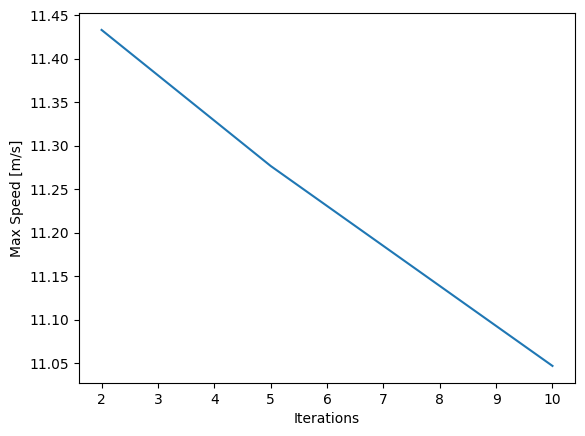

,iterations,maxSpeed,maximumSpeedSustained,sprintCount,distanceCovered
0,2,11.433291,400,12,4551.744210
1,5,11.276783,500,12,4550.535023
2,10,11.046717,500,12,4548.992465


In [14]:
metrics = []
for df in skillCornerSmoothDataFrames:
    metrics.append(extractMetrics(df))
    
maxSpeedList = list(map(lambda m: m['maxSpeed'], metrics))
print(maxSpeedList)
plt.plot(its, maxSpeedList, label='Cumulated Maximum Speed of trajectories')
plt.xlabel('Iterations')  # Replace 'Index' with the actual x-axis label
plt.ylabel('Max Speed [m/s]')  # Replace 'Value' with the actual y-axis label  
plt.show()
metrics = pd.DataFrame(metrics)
metrics['iterations'] = its
metrics = metrics[['iterations', 'maxSpeed', 'maximumSpeedSustained', 'sprintCount', 'distanceCovered']]
metrics

In [15]:
skillCornerSmoothDataFrames[0]

,match_id,half,frame_id,timestamp,object_id,x,y,z,extrapolated,arc_length,speed
0,1296476,1,100,0,59893,11.9,-14.62,0.0,False,-1.000000,NaN
1,1296476,1,101,100,59893,12.020763,-14.71901,0.0,False,0.156119,1.561193
2,1296476,1,102,200,59893,12.138337,-14.820825,0.0,False,0.154976,1.549765
3,1296476,1,103,300,59893,12.248026,-14.928261,0.0,False,0.152173,1.521734
4,1296476,1,104,400,59893,12.350302,-15.039141,0.0,False,0.149530,1.495301
...,...,...,...,...,...,...,...,...,...,...,...
19082,1296476,2,57983,3006300,59893,-36.045152,9.375199,0.0,False,0.286676,2.866764
19083,1296476,2,57984,3006400,59893,-35.960091,9.64272,0.0,False,0.274765,2.747655
19084,1296476,2,57985,3006500,59893,-35.874628,9.899467,0.0,False,0.266433,2.664335
19085,1296476,2,57986,3006600,59893,-35.788359,10.150507,0.0,False,0.264467,2.644672


As we can see, there is a significant jump in speed when using extrapolated data at frame 49780. Data at this frame says that the time difference between previous and current frame is still only 100ms => high speed. If we ignore extrapolated frames, we basically get something very similar to the smoothened metrics 

In [16]:
def smoothSkillcornerDataFrame(tracking_file_path, lineup_path, iterations, lines_to_smooth=2000000, teamName="FC Basel"):
    partialframes = read_csv_partially(tracking_file_path, 0, lines_to_smooth)
    lineup = read_csv_partially(lineup_path, 0, 33)

    targetTrajs = getTrajectories(teamName, lineup, partialframes)
    
    smoothDataFrames = pd.DataFrame()

    for player, trajs in targetTrajs.items():
        if player == []:
            continue

        for traj in trajs:
            if(len(traj) < 2):
                continue

            new_traj = performSmoothing(datapoints=traj, iterations=iterations)
            new_traj = pd.DataFrame(new_traj)
            new_traj[5] = player
            traj = pd.DataFrame(traj)
            for idx, row in traj.iterrows():
                if(isnan(row[4])):
                    print('nan')

            new_traj[4] = traj[4]

            smoothDataFrames = pd.concat([smoothDataFrames, new_traj], axis=0, ignore_index=True)

    origDF = pd.DataFrame(partialframes[1:])

    smoothDataFrames[4] = smoothDataFrames[4].astype(int)

    smoothDataFrames.columns = ['x', 'y', 'arc_length', 'time', 'frame_id', 'object_id']
    origDF.columns = ['match_id', 'half', 'frame_id', 'timestamp', 'object_id', 'x', 'y', 'z', 'extrapolated']

    origDF['frame_id'] = origDF['frame_id'].astype(int)
    mergedDF = origDF.merge(smoothDataFrames, how='left', on=['object_id', 'frame_id'])
    mergedDF['speed'] = mergedDF['arc_length']*10
    mergedDF = mergedDF[['match_id', 'half', 'frame_id', 'timestamp', 'object_id', 'x_y', 'y_y', 'z', 'extrapolated', 'speed']]
    mergedDF.columns = ['match_id', 'half', 'frame_id', 'timestamp', 'object_id', 'x', 'y', 'z', 'extrapolated', 'speed']
   
    return mergedDF


In [37]:
totalMetrics = pd.DataFrame(columns=['name', 'metrics'])
import pickle
# with open('dataframes/totalMetrics.pkl', 'wb') as file:
#     pickle.dump(totalMetrics, file)
metrics = pd.DataFrame({'name': 'giani', 'metrics': 0}, index=[0])
totalMetrics = pd.concat([totalMetrics, metrics], axis=0)
print(totalMetrics)
# print(totalMetrics)

with open('dataframes/totalMetricsStatsPerform.pkl', 'rb') as file:
    loaded_df = pickle.load(file)
    # print(loaded_df)
    print(loaded_df[loaded_df['name'] =='Schmid']['maxSpeed'])

    name metrics
0  giani       0
0    9.055518
1    9.044988
2    9.024827
3    8.875141
4    8.776615
5    8.746159
6    8.715083
Name: maxSpeed, dtype: float64
